![Ass 2 - Q4](Ass%202%20-Q4.png)


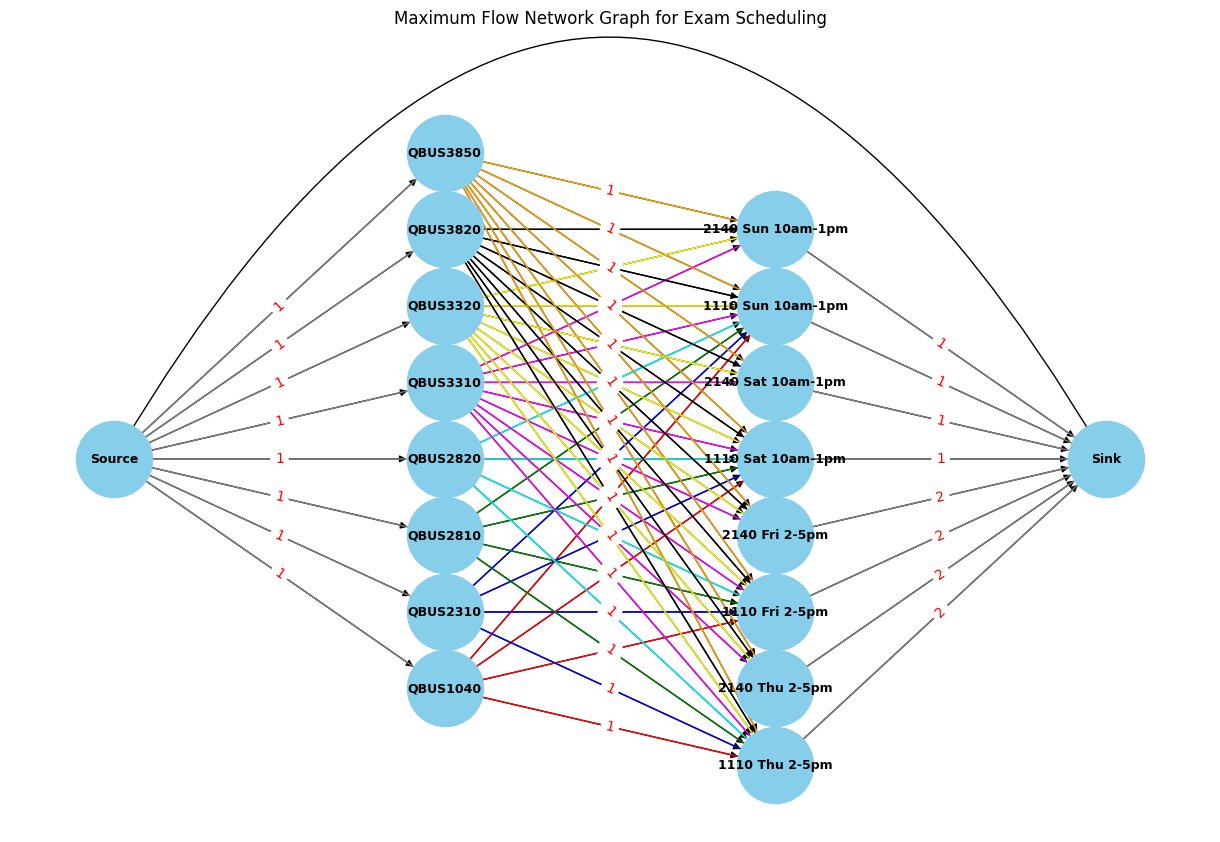

## 排课问题的最大流模型

### 节点
- **源点(S)**: 所有的流量都从源点开始。
- **课程节点(U)**: 每个课程代表一个节点。
- **教室时间槽节点(V)**: 每个特定教室和特定时间槽的组合都是一个节点。
- **汇点(T)**: 所有的流量都汇聚到这里。

### 边和容量
- **从源点到课程节点的边**: 每条边的容量为1，表示每个课程只能被安排一次。
- **从课程节点到教室时间槽节点的边**: 如果一个课程的学生人数不超过某个教室的容量，则这条边的容量为1，否则为0。
- **从教室时间槽节点到汇点的边**: 这条边的容量取决于时间槽的可接受考试数量。如周四和周五的容量为2，周六和周日的容量为1。

### 数学模型

1. **变量**
   - $x_{u,v}$: 二进制变量，如果课程 $u$ 安排在教室时间槽 $v$，则为1，否则为0。
   - $y_v$: 整数变量，表示从教室时间槽 $v$ 到汇点 $T$ 的流量。

2. **目标函数**
   - 最大化从所有教室时间槽到汇点的总流量：
   $$
   \text{Maximize} \quad \sum_{v \in V} y_v
   $$

3. **约束**
   - 每个课程最多只能安排一次：
   $$
   \sum_{v \in V} x_{u,v} \leq 1 \quad \forall u \in U
   $$
   - 教室时间槽的流量不能超过其容量，且流量必须等于该时间槽安排的考试数量：
   $$
   \sum_{u \in U} x_{u,v} = y_v \leq cap_v \quad \forall v \in V
   $$
   - 如果课程 $u$ 的学生人数超过教室 $v$ 的容量，则不允许流量：
   $$
   x_{u,v} = 0 \quad \text{if size of } u > \text{capacity of room in } v
   $$

通过这个模型，可以使用最大流算法找到可能的最大数量的考试安排，确保所有安排都符合教室容量和时间槽的限制。


In [9]:
import gurobipy as gp
from gurobipy import GRB

# 创建模型
mod = gp.Model('Exam_Scheduling')

# 添加节点
units = ['QBUS1040', 'QBUS2310', 'QBUS2810', 'QBUS2820', 'QBUS3310', 'QBUS3320', 'QBUS3820', 'QBUS3850']
times = ['Thu_2-5', 'Fri_2-5', 'Sat_10-1', 'Sun_10-1']
rooms = ['Room1110', 'Room2140']
unit_sizes = {'QBUS1040': 250, 'QBUS2310': 150, 'QBUS2810': 175, 'QBUS2820': 125, 'QBUS3310': 75, 'QBUS3320': 25, 'QBUS3820': 50, 'QBUS3850': 25}
room_capacities = {'Room1110': 300, 'Room2140': 100}

# 添加变量
x = mod.addVars(units, vtype=GRB.BINARY, name="Select_Unit")
y = mod.addVars([(u, t, r) for u in units for t in times for r in rooms if unit_sizes[u] <= room_capacities[r]], vtype=GRB.BINARY, name="Schedule")

# 目标函数：最大化安排的考试数量
mod.setObjective(gp.quicksum(y[u, t, r] for u in units for t in times for r in rooms if (u, t, r) in y), GRB.MAXIMIZE)

# 约束条件
# 每个单位最多安排一次考试
for u in units:
    mod.addConstr(gp.quicksum(y[u, t, r] for t in times for r in rooms if (u, t, r) in y) <= 1, name=f"Max_One_Exam_{u}")

# 每个时间-房间组合的容量限制
for t in times:
    for r in rooms:
        if t in ['Thu_2-5', 'Fri_2-5']:
            mod.addConstr(gp.quicksum(y[u, t, r] for u in units if (u, t, r) in y) <= 2, name=f"Cap_{t}_{r}")
        else:
            mod.addConstr(gp.quicksum(y[u, t, r] for u in units if (u, t, r) in y) <= 1, name=f"Cap_{t}_{r}")

# 更新模型并优化
mod.update()
mod.optimize()

# 输出结果
if mod.status == GRB.OPTIMAL:
    for v in mod.getVars():
        if v.x > 0.1:
            print(f"{v.VarName}: {v.x}")


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C64)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16 rows, 56 columns and 96 nonzeros
Model fingerprint: 0x29b77139
Variable types: 0 continuous, 56 integer (56 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 8.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 16 rows, 48 columns, 96 nonzeros
Variable types: 0 continuous, 48 integer (48 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.0000000